In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy.stats
import sklearn.model_selection
import natsort
import h5py

from pathlib import Path
import tensorflow as tf

from tqdm.auto import tqdm
tqdm.get_lock().locks = []

from IPython.core.display import display, HTML
import ipywidgets as widgets

import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns


import plotly.express as px
import plotly.offline as ply
import plotly.graph_objs as plygo
import cufflinks as cf
ply.init_notebook_mode(connected=False)
cf.set_config_file(offline=True, world_readable=False, theme='white')

In [2]:
from datasets.hsi_dataset import HSIDataset
from compression.spectral_ae import Autoencoder
from compression.classifier import Classifier

In [3]:
datasets = {'Suburban': '/storage/kiran/data/suburban/20170820_Urban_Ref_Reg_Subset.tif',
            'Urban': '/storage/kiran/data/urban/20170820_Urban2_INT_Final.tif',
            'Forest': '/storage/kiran/data/forest/20170820_Forest_Final_INT.tif'
           }

/storage/kiran/results/data/prediction_Suburban_HSI_KPCA_1_0.00.h5
/storage/kiran/results/data/prediction_Suburban_HSI_PCA_1_0.00.h5
/storage/kiran/results/data/prediction_Suburban_HSI_ICA_1_0.00.h5
/storage/kiran/results/data/prediction_Suburban_HSI_AE_1_0.00.h5
/storage/kiran/results/data/prediction_Suburban_HSI_DAE_1_0.00.h5


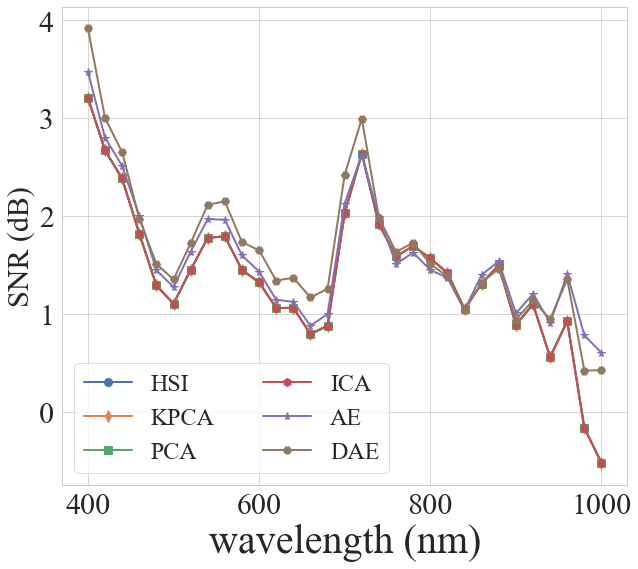

/storage/kiran/results/data/prediction_Urban_HSI_KPCA_1_0.00.h5
/storage/kiran/results/data/prediction_Urban_HSI_PCA_1_0.00.h5
/storage/kiran/results/data/prediction_Urban_HSI_ICA_1_0.00.h5
/storage/kiran/results/data/prediction_Urban_HSI_AE_1_0.00.h5
/storage/kiran/results/data/prediction_Urban_HSI_DAE_1_0.00.h5


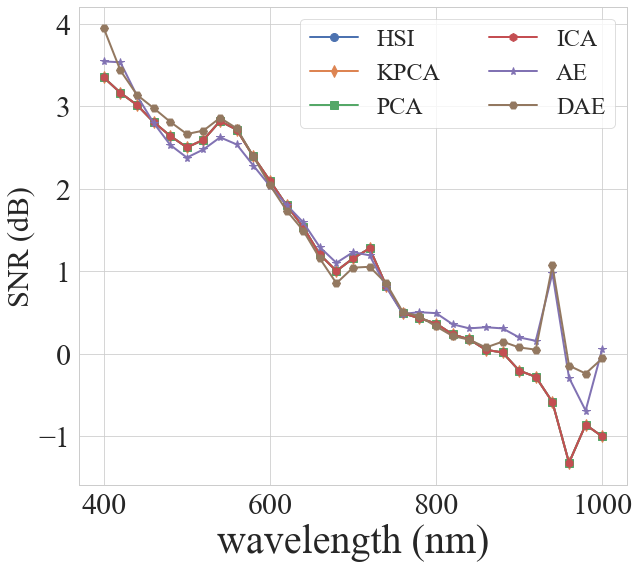

/storage/kiran/results/data/prediction_Forest_HSI_KPCA_1_0.00.h5
/storage/kiran/results/data/prediction_Forest_HSI_PCA_1_0.00.h5
/storage/kiran/results/data/prediction_Forest_HSI_ICA_1_0.00.h5
/storage/kiran/results/data/prediction_Forest_HSI_AE_1_0.00.h5
/storage/kiran/results/data/prediction_Forest_HSI_DAE_1_0.00.h5


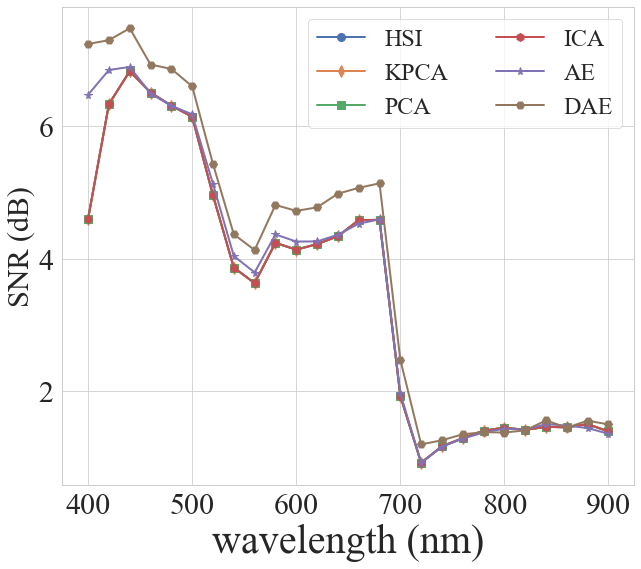

In [4]:
sns.set(context='paper',font="Times New Roman", style="whitegrid")
#plt.xkcd()

for idx, (dataset_name) in enumerate(datasets):    
    dataset = HSIDataset(datasets[dataset_name], dataset_name)

    compression_classes = ['KPCA','PCA', 'ICA','AE', 'DAE']
    fig, axs = plt.subplots(1,1, figsize=(9,8), sharey=True, sharex=True)
    axs = [axs]
    df = pd.DataFrame()
    for compression_class in compression_classes:        
        file = [str(item) for item in Path('/storage/kiran/results/data/').glob(f"*{dataset_name}*_{compression_class}_1*_0.00.h5") if '_SG_' not in str(item)]
        file = natsort.realsorted(file)[0]
        print(file)
        results_file = h5py.File(file,'r')
                
        test_samples = results_file['test_samples']
        reconstructed_samples = results_file['reconstructed_test_samples']        
                
        snr_samples = test_samples[()].mean(axis=0) / test_samples[()].std(axis=0)
        snr_reconstructed = reconstructed_samples[()].mean(axis=0) / reconstructed_samples[()].std(axis=0)

        df['HSI'] = 10*np.log10(snr_samples)
        df[compression_class] = 10*np.log10(snr_reconstructed)
        
    marker = ['o','d','s','h','*','H']
    for j, c in enumerate(df):
        curve = df[c]            
        line = axs[0].plot(dataset.hsi_bands[::10], curve[::10], lw=2, label=f"{c}", alpha=1, marker=marker[j], ms=8)

    # axs[0].set_title(f"{dataset.name}", fontsize=40)     
    axs[0].set_xlabel("wavelength (nm)", fontsize=40)

    axs[0].set_ylabel("SNR (dB)", fontsize=30)        
    axs[0].tick_params(axis='x', labelsize=30)
    axs[0].tick_params(axis='y', labelsize=30)
    #axs[0].set_yscale('log')
    axs[0].legend(fontsize=24, loc='best', ncol=2)
    
    # axs[0].grid(False)
    
    plt.tight_layout()
    plt.savefig(f'/storage/kiran/results/charts/snr_{dataset_name}.pdf')
    plt.show()        

In [ ]:
sns.set(context='paper',font="Times New Roman", style="whitegrid")
#plt.xkcd()

for idx, (dataset_name) in enumerate(datasets):    
    # DAE
    filename_dae_hsi = [item for item in Path('/storage/kiran/models/DAE_1').glob(f"*{dataset_name}*") if "HSI_301" in str(item) or "HSI_251" in str(item)][-1]
    dae_hsi = Autoencoder.load(filename_dae_hsi)    
    
    # filename_dae_hsi_sg = [item for item in Path('/storage/kiran/models/DAE_1').glob(f"*{dataset_name}*") if "HSI_SG_301" in str(item) or "HSI_SG_251" in str(item)][-1]        
    # dae_hsi_sg = Autoencoder.load(filename_dae_hsi_sg)

    # AE
    filename_ae_hsi = [item for item in Path('/storage/kiran/models/AE_1').glob(f"*{dataset_name}*") if "HSI_301" in str(item) or "HSI_251" in str(item)][-1]    
    ae_hsi = Autoencoder.load(filename_ae_hsi)

    # filename_ae_hsi_sg = [item for item in Path('/storage/kiran/models/AE_1').glob(f"*{dataset_name}*") if "HSI_SG_301" in str(item) or "HSI_SG_251" in str(item)][-1]
    # ae_hsi_sg = Autoencoder.load(filename_ae_hsi_sg)
    
    
    # Dataset
    dataset = HSIDataset(datasets[dataset_name], dataset_name)        
    labels, data = dataset.trainingset
    
    mean = dataset.hsi.reshape(dataset.n_pixels, -1).mean(axis=0)
    stddev = dataset.hsi.reshape(dataset.n_pixels, -1).std(axis=0)          
    snr = 10*np.log10((mean/stddev).ravel())
    
    print(dataset_name, dataset.name, dataset.hsi.shape, snr.shape)
    
    category_id = labels.get('Vegetation', False) or labels.get('Lawn', False) or labels.get('Tree', None)
    
    #X = dataset[int(dataset.n_pixels*(3/4))].reshape(1, dataset.n_bands)
    X = dataset.hsi    
    X = X[data==category_id][0].reshape(1, dataset.n_bands)
    
    # SG
    X_sg = scipy.signal.savgol_filter(X, window_length=25, polyorder=3, mode='interp', axis=1)

    # Reconstruct
    X_reconstructed_dae_hsi = dae_hsi(X).numpy()
    # X_reconstructed_dae_hsi_sg = dae_hsi_sg(X).numpy()

    X_reconstructed_ae_hsi = ae_hsi(X).numpy()
    # X_reconstructed_ae_hsi_sg = ae_hsi_sg(X).numpy()
    
    df = pd.DataFrame()
    df['HSI'] = X.ravel()    
    #df['HSI +SG'] = X_sg.ravel()   
    
    #df['HSI +AE'] = X_reconstructed_ae_hsi.ravel()
    # df['HSI +SG,AE'] = X_reconstructed_ae_hsi_sg.ravel()

    #df['HSI +DAE'] = X_reconstructed_dae_hsi.ravel()
    #df['HSI +SG,DAE'] = X_reconstructed_dae_hsi_sg.ravel()    
    
    fig, axs = plt.subplots(1,1, figsize=(10,8), sharey=False, sharex=False)
    axs = [axs]
    
    idx = 0
    linestyles=['-','-.',':']*10
    for j, c in enumerate(df):
        curve = df[c]
        lns_1 = axs[idx].plot(dataset.hsi_bands, curve, lw=1, label=c, alpha=1, linestyle=linestyles[j], color='k', marker='+')
        axs[idx].set_title(f"{dataset.name}", fontsize=30, fontfamily="Times New Roman")
        # axs[idx].set_xlabel("wavelength (nm)", fontsize=30, fontfamily="Times New Roman")
        
    
    axs_2 = axs[idx].twinx()
    lns_2 = axs_2.plot(dataset.hsi_bands[::10], snr[::10], lw=2, label="SNR", alpha=1, linestyle='-', marker='o')
    #axs[idx].set_title(f"{dataset.name}", fontsize=40, fontfamily="Times New Roman")
    #axs[idx].set_xlabel("wavelength (nm)", fontsize=40, fontfamily="Times New Roman")

        
    axs[0].set_ylabel("reflectance", fontsize=30)    
    axs[0].tick_params(axis='x', labelsize=30)
    axs[0].tick_params(axis='y', labelsize=30)
    #if dataset_name=='Suburban':
    axs[0].set_ylim(ymax=1.0)

    axs_2.set_ylabel("SNR", fontsize=30)
    axs_2.tick_params(axis='y', labelsize=30)
    #axs_2.set_yticks(axs[0].get_yticks())

    lns = lns_1+lns_2    
    labs = [l.get_label() for l in lns]
    axs[0].legend(lns, labs, ncol=1, fontsize=25, loc=9)
    plt.tight_layout()
    
#     axs[0].grid(False)
    axs_2.grid(False)

    plt.savefig(f'/storage/kiran/results/charts/hsi_bands_sample_pixel_{dataset_name}.pdf')
    plt.show()


In [ ]:
sns.set(context='paper',font="Times New Roman", style="whitegrid")
#plt.xkcd()

for idx, (dataset_name) in enumerate(datasets):    
    # DAE
    filename_dae_hsi = [item for item in Path('/storage/kiran/models/DAE_1').glob(f"*{dataset_name}*") if "HSI_301" in str(item) or "HSI_251" in str(item)][-1]
    dae_hsi = Autoencoder.load(filename_dae_hsi)    
    
    filename_dae_hsi_sg = [item for item in Path('/storage/kiran/models/DAE_1').glob(f"*{dataset_name}*") if "HSI_SG_301" in str(item) or "HSI_SG_251" in str(item)][-1]        
    dae_hsi_sg = Autoencoder.load(filename_dae_hsi_sg)

    # AE
    filename_ae_hsi = [item for item in Path('/storage/kiran/models/AE_1').glob(f"*{dataset_name}*") if "HSI_301" in str(item) or "HSI_251" in str(item)][-1]    
    ae_hsi = Autoencoder.load(filename_ae_hsi)

    filename_ae_hsi_sg = [item for item in Path('/storage/kiran/models/AE_1').glob(f"*{dataset_name}*") if "HSI_SG_301" in str(item) or "HSI_SG_251" in str(item)][-1]
    ae_hsi_sg = Autoencoder.load(filename_ae_hsi_sg)
    
    
    # Dataset
    dataset = HSIDataset(datasets[dataset_name], dataset_name)        
    labels, data = dataset.trainingset
    
    mean = dataset.hsi.reshape(dataset.n_pixels, -1).mean(axis=0)
    stddev = dataset.hsi.reshape(dataset.n_pixels, -1).std(axis=0)          
    snr = 10*np.log10((mean/stddev).ravel())
    
    print(dataset_name, dataset.name, dataset.hsi.shape, snr.shape)
    
    category_id = labels.get('Vegetation', False) or labels.get('Lawn', False) or labels.get('Tree', None)
    
    #X = dataset[int(dataset.n_pixels*(3/4))].reshape(1, dataset.n_bands)
    X = dataset.hsi    
    X = X[data==category_id][0].reshape(1, dataset.n_bands)
    
    # SG
    X_sg = scipy.signal.savgol_filter(X, window_length=25, polyorder=3, mode='interp', axis=1)

    # Reconstruct
    X_reconstructed_dae_hsi = dae_hsi(X).numpy()
    X_reconstructed_dae_hsi_sg = dae_hsi_sg(X).numpy()

    X_reconstructed_ae_hsi = ae_hsi(X).numpy()
    X_reconstructed_ae_hsi_sg = ae_hsi_sg(X).numpy()
    
    df = pd.DataFrame()
    df['HSI'] = X.ravel()    
    df['HSI +SG'] = X_sg.ravel()   
    
    df['HSI +AE'] = X_reconstructed_ae_hsi.ravel()
    df['HSI +SG,AE'] = X_reconstructed_ae_hsi_sg.ravel()

    df['HSI +DAE'] = X_reconstructed_dae_hsi.ravel()
    df['HSI +SG,DAE'] = X_reconstructed_dae_hsi_sg.ravel()    
    
    fig, axs = plt.subplots(1,1, figsize=(10,8), sharey=False, sharex=False)
    axs = [axs]
    
    idx = 0
    linestyles=['-','-.',':']*10
    for j, c in enumerate(df):
        curve = df[c]
        lns_1 = axs[idx].plot(dataset.hsi_bands, curve, lw=1, label=c, alpha=1, linestyle=linestyles[j], color='k', marker='+')
        axs[idx].set_title(f"{dataset.name}", fontsize=30, fontfamily="Times New Roman")
        # axs[idx].set_xlabel("wavelength (nm)", fontsize=30, fontfamily="Times New Roman")
        
    
    axs_2 = axs[idx].twinx()
    lns_2 = axs_2.plot(dataset.hsi_bands[::10], snr[::10], lw=2, label="SNR", alpha=1, linestyle='-', marker='o')
    #axs[idx].set_title(f"{dataset.name}", fontsize=40, fontfamily="Times New Roman")
    #axs[idx].set_xlabel("wavelength (nm)", fontsize=40, fontfamily="Times New Roman")

        
    axs[0].set_ylabel("reflectance", fontsize=30)    
    axs[0].tick_params(axis='x', labelsize=30)
    axs[0].tick_params(axis='y', labelsize=30)
    #if dataset_name=='Suburban':
    axs[0].set_ylim(ymax=1.0)

    axs_2.set_ylabel("SNR", fontsize=30)
    axs_2.tick_params(axis='y', labelsize=30)
    #axs_2.set_yticks(axs[0].get_yticks())

    lns = lns_1+lns_2    
    labs = [l.get_label() for l in lns]
    axs[0].legend(lns, labs, ncol=1, fontsize=25, loc=9)
    plt.tight_layout()
    
    # axs[0].grid(False)
    axs_2.grid(False)

    plt.savefig(f'/storage/kiran/results/charts/hsi_bands_sample_pixel_{dataset_name}.pdf')
    plt.show()


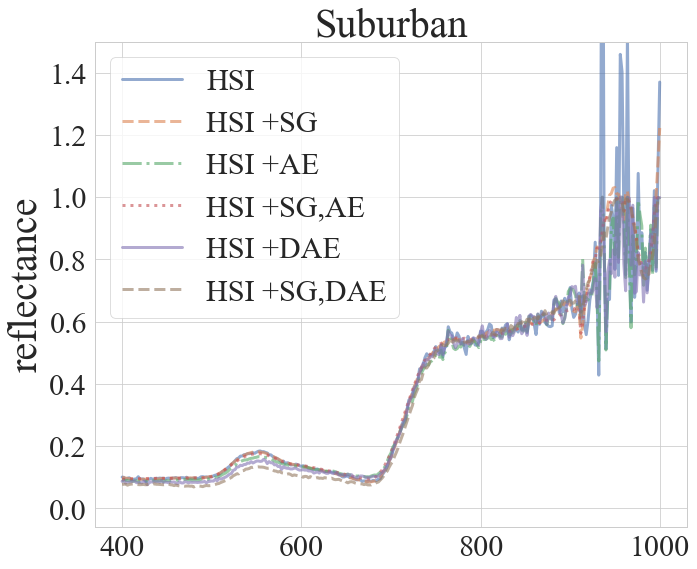

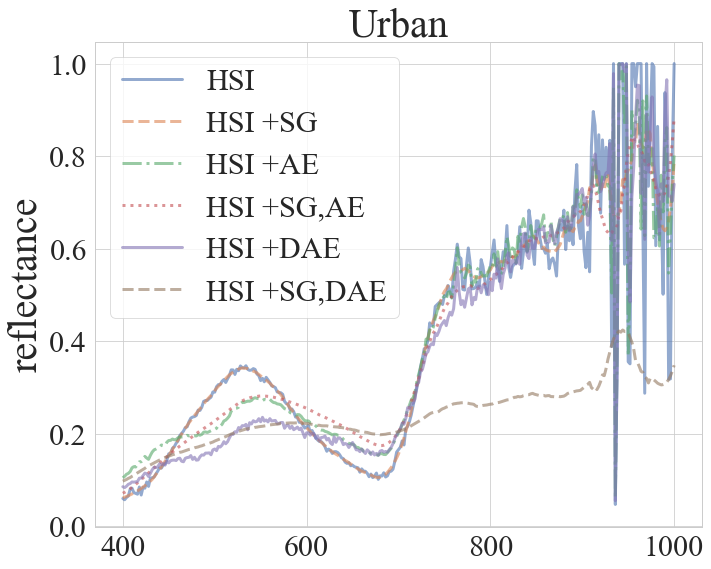

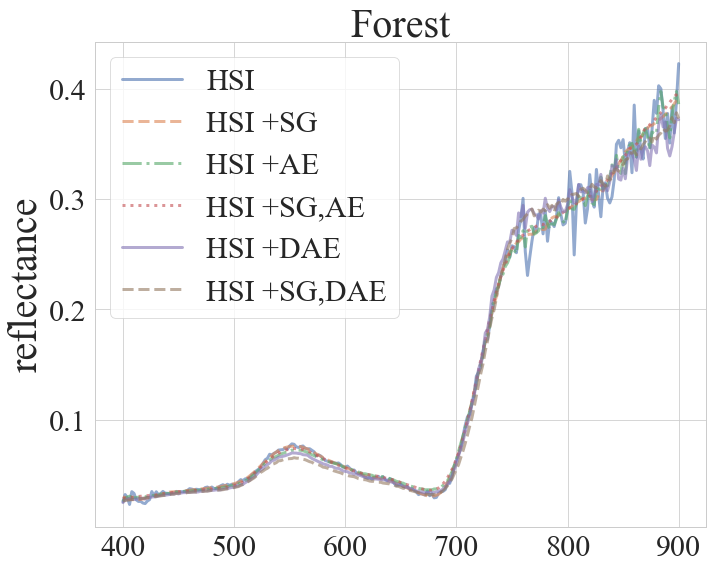

In [5]:
sns.set(context='paper',font="Times New Roman", style="whitegrid")
#plt.xkcd()


for idx, (dataset_name) in enumerate(datasets):
    fig, axs = plt.subplots(1,1, figsize=(10,8), sharey=False, sharex=False)
    axs = [axs]
    # DAE
    filename_dae_hsi = [item for item in Path('/storage/kiran/models/DAE_1').glob(f"*{dataset_name}*") if "HSI_301" in str(item) or "HSI_251" in str(item)][-1]
    filename_dae_hsi_sg = [item for item in Path('/storage/kiran/models/DAE_1').glob(f"*{dataset_name}*") if "HSI_SG_301" in str(item) or "HSI_SG_251" in str(item)][-1]    
    dae_hsi = Autoencoder.load(filename_dae_hsi)    
    dae_hsi_sg = Autoencoder.load(filename_dae_hsi_sg)


    # AE
    filename_ae_hsi = [item for item in Path('/storage/kiran/models/AE_1').glob(f"*{dataset_name}*") if "HSI_301" in str(item) or "HSI_251" in str(item)][-1]    
    filename_ae_hsi_sg = [item for item in Path('/storage/kiran/models/AE_1').glob(f"*{dataset_name}*") if "HSI_SG_301" in str(item) or "HSI_SG_251" in str(item)][-1]
    ae_hsi = Autoencoder.load(filename_ae_hsi)
    ae_hsi_sg = Autoencoder.load(filename_ae_hsi_sg)
    
    
    # Dataset
    dataset = HSIDataset(datasets[dataset_name], dataset_name)        
    labels, data = dataset.trainingset
    
    data.reshape(-1,1)    
    category_id = labels.get('Vegetation', False) or labels.get('Lawn', False) or labels.get('Tree', None)
    
    #X = dataset[int(dataset.n_pixels*(3/4))].reshape(1, dataset.n_bands)
    X = dataset.hsi    
    X = X[data==category_id][0].reshape(1, dataset.n_bands)
    
    # SG
    X_sg = scipy.signal.savgol_filter(X, window_length=25, polyorder=3, mode='interp', axis=1)

    # Reconstruct
    X_reconstructed_dae_hsi = dae_hsi(X).numpy()
    X_reconstructed_dae_hsi_sg = dae_hsi_sg(X).numpy()

    X_reconstructed_ae_hsi = ae_hsi(X).numpy()
    X_reconstructed_ae_hsi_sg = ae_hsi_sg(X).numpy()
    
    df = pd.DataFrame()
    df['HSI'] = X.ravel()
    df['HSI +SG'] = X_sg.ravel()   
    
    df['HSI +AE'] = X_reconstructed_ae_hsi.ravel()
    df['HSI +SG,AE'] = X_reconstructed_ae_hsi_sg.ravel()

    df['HSI +DAE'] = X_reconstructed_dae_hsi.ravel()
    df['HSI +SG,DAE'] = X_reconstructed_dae_hsi_sg.ravel()    
    
    idx = 0
    linestyles=['-','--','-.',':']*10
    for j, c in enumerate(df):
        curve = df[c]
        axs[idx].plot(dataset.hsi_bands, curve, lw=3, label=c, alpha=0.6, linestyle=linestyles[j])
        axs[idx].set_title(f"{dataset.name}", fontsize=40, fontfamily="Times New Roman")
        # axs[idx].set_xlabel("wavelength (nm)", fontsize=40, fontfamily="Times New Roman")
        
    axs[0].set_ylabel("reflectance", fontsize=40)
    axs[0].tick_params(axis='x', labelsize=30)
    axs[0].tick_params(axis='y', labelsize=30)
    if dataset_name=='Suburban':
        axs[0].set_ylim(ymax=1.5)
        
    axs[-1].legend(ncol=1, fontsize=30)

    plt.tight_layout()
    plt.savefig(f'/storage/kiran/results/charts/hsi_bands_sample_pixel_{dataset_name}.pdf')
    plt.show()
